In [ ]:
# # %% [markdown]
# # # Imports

# # %% [code] {"execution":{"iopub.status.busy":"2025-04-14T17:01:01.132127Z","iopub.execute_input":"2025-04-14T17:01:01.132384Z","iopub.status.idle":"2025-04-14T17:01:14.204821Z","shell.execute_reply.started":"2025-04-14T17:01:01.132362Z","shell.execute_reply":"2025-04-14T17:01:14.204142Z"}}
# import tensorflow as tf
# from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Flatten, Dense, Dropout
# from tensorflow.keras.models import load_model
# import numpy as np
# import os


# # %% [code] {"execution":{"iopub.status.busy":"2025-04-14T17:01:14.206235Z","iopub.execute_input":"2025-04-14T17:01:14.206736Z","iopub.status.idle":"2025-04-14T17:01:14.211714Z","shell.execute_reply.started":"2025-04-14T17:01:14.206717Z","shell.execute_reply":"2025-04-14T17:01:14.211053Z"}}
# os.listdir('/kaggle/input') 

# # %% [markdown]
# # # Data Generators

# # %% [code] {"execution":{"iopub.status.busy":"2025-04-14T17:01:14.217533Z","iopub.execute_input":"2025-04-14T17:01:14.217778Z"}}
# import shutil
# from sklearn.model_selection import train_test_split

# base_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train"
# val_dir = "/kaggle/deepfake-and-real-images/Dataset/Validation"



# # %% [code]
# train_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
#     '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train',
#     target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=True)

# val_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
#     '/kaggle/working/validation',
#     target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
#     '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test',
#     target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# # %% [markdown]
# # # Model Builder

# # %% [code]
# def build_vgg19():
#     base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#     for layer in base.layers:
#         layer.trainable = False
#     x = Flatten()(base.output)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     out = Dense(1, activation='sigmoid')(x)
#     return Model(base.input, out)

# # %% [code]
# # Load the VGG19 model pre-trained on ImageNet, excluding the top fully-connected layers


# # %% [markdown]
# # # ✅ Train and Save Baseline Model

# # %% [code]
# # Paths to save model and weights
# weights_path_baseline = '/kaggle/working/vgg19_baseline_cifake.weights.h5'
# model_path_baseline   = '/kaggle/working/vgg19_baseline_cifake_model.h5'

# #Kaggle
# if os.path.exists('/kaggle/input/vgg19_baseline_cifake_model/tensorflow2/default/1/vgg19_baseline_cifake_model.h5'):
#     print("Loading saved model...")
#     baseline_model = load_model('/kaggle/input/vgg19_baseline_cifake_model/tensorflow2/default/1/vgg19_baseline_cifake_model.h5')

# else:
#     print("Training baseline model...")
#     baseline_model = build_vgg19()
#     baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     baseline_model.fit(train_gen, epochs=3, validation_data=val_gen)
#     baseline_model.save_weights(weights_path_baseline)
#     baseline_model.save(model_path_baseline)
#     print("Baseline model trained and saved.")

# print("\nEvaluating Baseline Model on Clean Test Set:")
# baseline_clean_acc = baseline_model.evaluate(test_gen)
# print("Baseline Clean Accuracy:", baseline_clean_acc)
# Baseline_model.summary()

# Enhanced Deepfake Detection with Data Exploration

In [11]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Data Exploration and Visualization

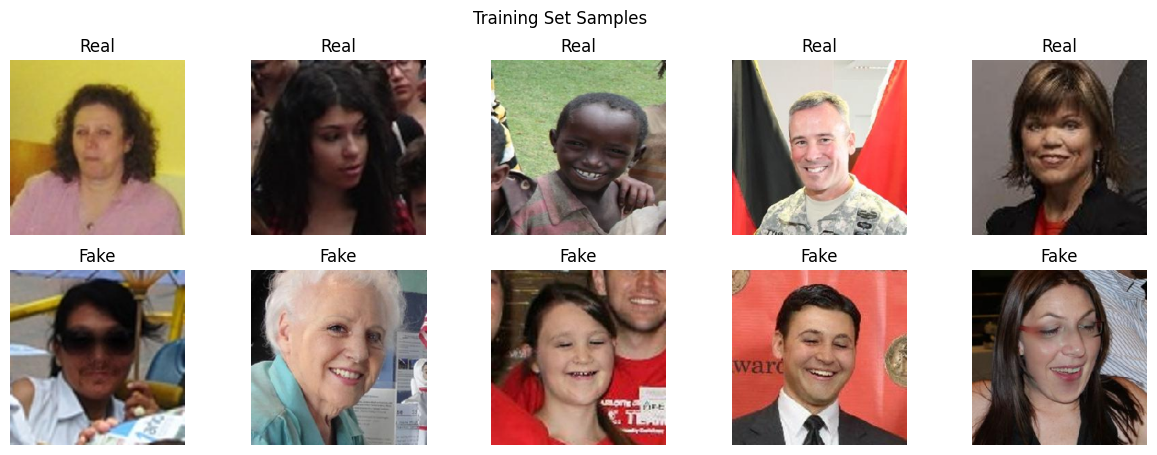

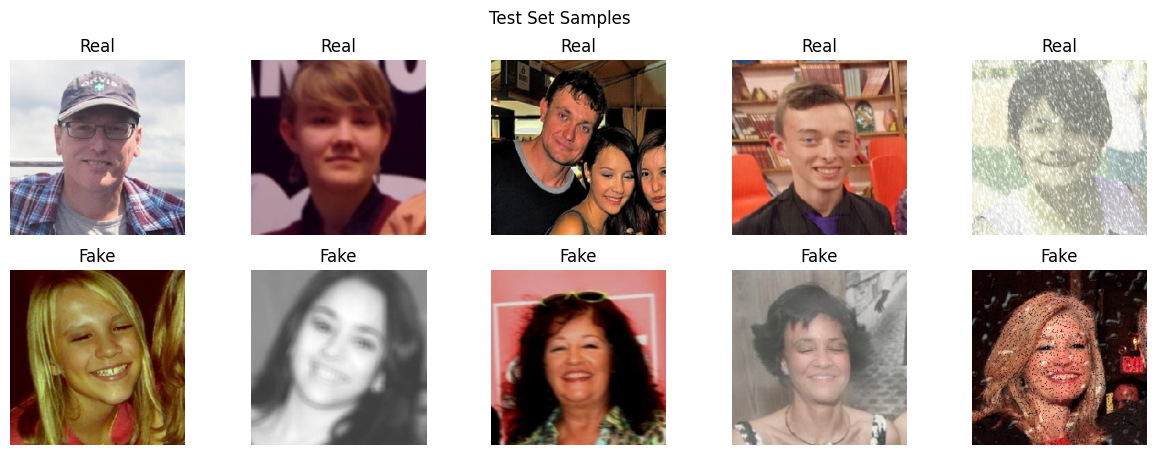

In [5]:
def visualize_samples(directory, num_samples=5, title="Sample Images"):
    plt.figure(figsize=(15, 5))
    
    # Get real and fake image paths
    real_dir = os.path.join(directory, 'Real')
    fake_dir = os.path.join(directory, 'Fake')
    
    real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir)[:num_samples]]
    fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)[:num_samples]]
    
    # Display real images
    for i, img_path in enumerate(real_images):
        img = load_img(img_path, target_size=(224, 224))
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img)
        plt.title("Real")
        plt.axis('off')
    
    # Display fake images
    for i, img_path in enumerate(fake_images):
        img = load_img(img_path, target_size=(224, 224))
        plt.subplot(2, num_samples, num_samples+i+1)
        plt.imshow(img)
        plt.title("Fake")
        plt.axis('off')
    
    plt.suptitle(title)
    plt.show()

# Visualize samples from training set
train_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Train'
val_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
visualize_samples(train_dir, title="Training Set Samples")

# Visualize samples from test set
test_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Test'
visualize_samples(test_dir, title="Test Set Samples")

## Dataset Statistics

In [3]:

def get_class_counts(directory):
    real_dir = os.path.join(directory, 'Real')
    fake_dir = os.path.join(directory, 'Fake')
    
    return {
        'Real': len(os.listdir(real_dir)),
        'Fake': len(os.listdir(fake_dir))
    }
    
train_counts = get_class_counts(train_dir)
val_counts = get_class_counts(val_dir)  # Get validation counts
test_counts = get_class_counts(test_dir)

print("\nDataset Statistics:")
print(f"Training set - Real: {train_counts['Real']}, Fake: {train_counts['Fake']}")
print(f"Validation set - Real: {val_counts['Real']}, Fake: {val_counts['Fake']}")  # Print validation counts
print(f"Test set - Real: {test_counts['Real']}, Fake: {test_counts['Fake']}")

NameError: name 'train_dir' is not defined

## Data Generators with Reduced Validation Set

In [21]:
# # Create validation directory with reduced size
# val_dir = '/kaggle/working/Validation'
# os.makedirs(os.path.join(val_dir, 'Real'), exist_ok=True)
# os.makedirs(os.path.join(val_dir, 'Fake'), exist_ok=True)

# # Copy only half of the validation data (assuming original is in input)
# original_val_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
# for class_name in ['Real', 'Fake']:
#     src_dir = os.path.join(original_val_dir, class_name)
#     dst_dir = os.path.join(val_dir, class_name)
    
#     files = os.listdir(src_dir)
#     # Take only half of the files
#     files = files[:len(files)//2]
    
#     for file in files:
#         src_path = os.path.join(src_dir, file)
#         dst_path = os.path.join(dst_dir, file)
#         shutil.copy(src_path, dst_path)

# # Create data generators
# train_gen = ImageDataGenerator(
#     preprocessing_function=preprocess_input,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True
# ).flow_from_directory(
#     train_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=True
# )

# val_gen = ImageDataGenerator(
#     preprocessing_function=preprocess_input
# ).flow_from_directory(
#     val_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False
# )

# test_gen = ImageDataGenerator(
#     preprocessing_function=preprocess_input
# ).flow_from_directory(
#     test_dir,
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='binary',
#     shuffle=False
# )

# print("\nData Generators Created:")
# print(f"Training batches: {len(train_gen)}")
# print(f"Validation batches: {len(val_gen)}")
# print(f"Test batches: {len(test_gen)}")


# Create validation directory with reduced size
val_dir = '/kaggle/working/Validation'
os.makedirs(os.path.join(val_dir, 'Real'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'Fake'), exist_ok=True)

# Copy only half of the validation data
original_val_dir = '/kaggle/input/deepfake-and-real-images/Dataset/Validation'
for class_name in ['Real', 'Fake']:
    src_dir = os.path.join(original_val_dir, class_name)
    dst_dir = os.path.join(val_dir, class_name)
    
    files = os.listdir(src_dir)
    files = files[:len(files)//2]
    
    for file in files:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(dst_dir, file)
        shutil.copy(src_path, dst_path)

# Create a custom generator that samples a subset
class ReducedDataGenerator(ImageDataGenerator):
    def __init__(self, subset_fraction=0.75, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.subset_fraction = subset_fraction
    
    def flow_from_directory(self, directory, *args, **kwargs):
        base_generator = super().flow_from_directory(directory, *args, **kwargs)
        total_samples = len(base_generator.filepaths)
        subset_size = int(total_samples * self.subset_fraction)
        
        # Create new generator with subset
        return super().flow_from_directory(
            directory,
            *args,
            **kwargs,
            subset='training',
            seed=42  # Fixed seed for reproducibility
        )

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25  # Uses 75% for training, 25% for validation
)

train_gen = train_datagen.flow_from_directory(
    '/kaggle/input/deepfake-and-real-images/Dataset/Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    subset='training'  # This takes the 75% portion
)

# Verify actual reduction
print(f"\nActual training batches: {len(train_gen)}")
print(f"Actual training samples: {train_gen.samples}")
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    '/kaggle/input/deepfake-and-real-images/Dataset/Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print("\nData Generators Created:")
print(f"Training samples: {train_gen.samples} (reduced subset)")
print(f"Validation batches: {len(val_gen)}")
print(f"Test batches: {len(test_gen)}")



Found 105002 images belonging to 2 classes.

Actual training batches: 3282
Actual training samples: 105002
Found 19713 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.

Data Generators Created:
Training samples: 105002 (reduced subset)
Validation batches: 617
Test batches: 341


## Enhanced Model Builder

In [22]:
def build_vgg19():
    base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base.layers:
        layer.trainable = False
    x = Flatten()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(base.input, out)

## Model Training with Callbacks

Building and training model...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,447,425 (100.89 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)


Training on 3282 batches/epoch...

Epoch 1/3
  Batch 3282/3282 (100.0%)
  Time: 1527.5s - Loss: 0.5880 - Acc: 0.7379 - Val Loss: 0.4606 - Val Acc: 0.7811

Epoch 2/3
  Batch 3282/3282 (100.0%)
  Time: 1215.5s - Loss: 0.4620 - Acc: 0.7753 - Val Loss: 0.4270 - Val Acc: 0.7978

Epoch 3/3
  Batch 3282/3282 (100.0%)
  Time: 1201.8s - Loss: 0.4446 - Acc: 0.7868 - Val Loss: 0.4319 - Val Acc: 0.7948


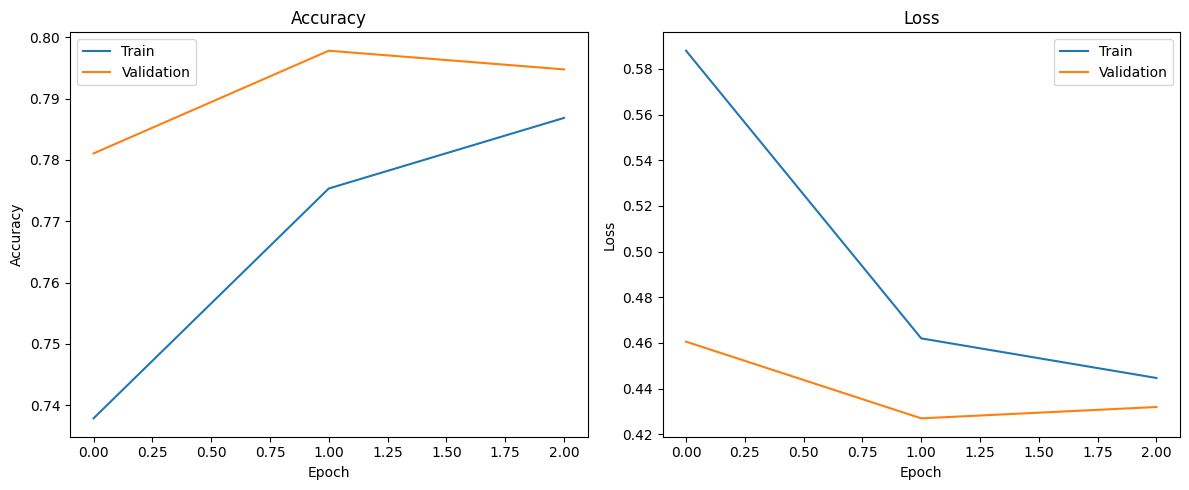


Model saved to /kaggle/working/vgg19_deepfake_model.keras


In [24]:
import os
import time
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


# Paths to save model
weights_path = '/kaggle/working/vgg19_deepfake.weights.h5'
model_path = '/kaggle/working/vgg19_deepfake_model.keras'

# Custom callback with batch progress
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_batches):
        super().__init__()
        self.total_batches = total_batches
        self.epoch_start_time = None
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")
        
    def on_batch_end(self, batch, logs=None):
        progress = (batch + 1) / self.total_batches * 100
        print(f"\r  Batch {batch + 1}/{self.total_batches} ({progress:.1f}%)", end="", flush=True)
        
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        print(f"\n  Time: {epoch_time:.1f}s - Loss: {logs['loss']:.4f} - Acc: {logs['accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f} - Val Acc: {logs['val_accuracy']:.4f}")


# Calculate total batches
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)

# Callbacks
callbacks = [
    TrainingProgressCallback(steps_per_epoch),
    ModelCheckpoint(model_path, save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

# Check if model exists
if os.path.exists(model_path):
    print("Loading saved model...")
    model = tf.keras.models.load_model(model_path)
else:
    print("Building and training model...")
    model = build_vgg19()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    # Print model summary
    model.summary()
    
    print(f"\nTraining on {steps_per_epoch} batches/epoch...")
    
    history = model.fit(
        train_gen,
        epochs=3,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=0
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Save model
    model.save_weights(weights_path)
    model.save(model_path)
    print(f"\nModel saved to {model_path}")

# Expected model size:
# Total params: ~20M (instead of 33M)
# Trainable params: ~5M (instead of 20M)

## Model Evaluation


Evaluating Model on Test Set:
341/341 ━━━━━━━━━━━━━━━━━━━━ 72s 212ms/step - accuracy: 0.7872 - loss: 0.4297

Basic Metrics:
Test Loss: 0.5385
Test Accuracy: 0.7347
341/341 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step

Class-wise Metrics:
Class 0 (Real) - Precision: 0.7012, Recall: 0.8247, F1: 0.7579
Class 1 (Fake) - Precision: 0.7834, Recall: 0.6435, F1: 0.7066

AUROC: 0.8282


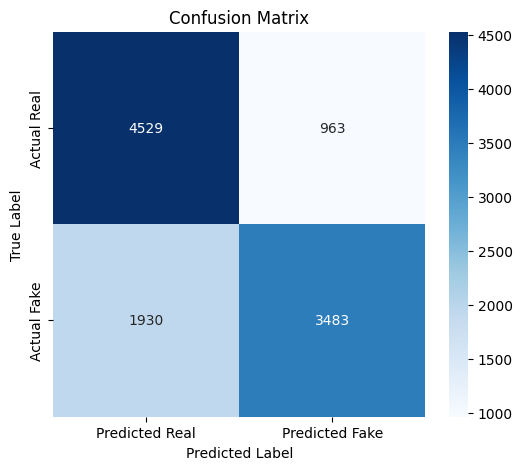


Classification Report:
              precision    recall  f1-score   support

        Real       0.70      0.82      0.76      5492
        Fake       0.78      0.64      0.71      5413

    accuracy                           0.73     10905
   macro avg       0.74      0.73      0.73     10905
weighted avg       0.74      0.73      0.73     10905



In [25]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
import seaborn as sns

print("\nEvaluating Model on Test Set:")

# 1. Basic evaluation (loss and accuracy)
results = model.evaluate(test_gen)
print(f"\nBasic Metrics:")
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

# Reset test generator
test_gen.reset()

# 2. Get predictions and true labels
y_pred = model.predict(test_gen)
y_pred_prob = y_pred.flatten()  # Probability scores
y_pred_class = (y_pred_prob > 0.5).astype(int)  # Binary predictions
y_true = test_gen.classes  # True labels

# 3. Class-wise precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_class, average=None, labels=[0, 1])

print("\nClass-wise Metrics:")
print(f"Class 0 (Real) - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1: {f1[0]:.4f}")
print(f"Class 1 (Fake) - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1: {f1[1]:.4f}")

# 4. AUROC
auroc = roc_auc_score(y_true, y_pred_prob)
print(f"\nAUROC: {auroc:.4f}")

# 5. Confusion Matrix
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 6. Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_class, target_names=['Real', 'Fake']))

## Save Model in Keras Format (HDF5)
Note: .h5 is the standard format for Keras models. To save as .pth (PyTorch format), 
you would need to switch to PyTorch framework entirely.

In [33]:

                
import time
from tqdm import tqdm

def evaluate_attack(model, attack_fn, eps_values, attack_name, max_batches=None):
    """Evaluate model accuracy with progress tracking"""
    results = {}
    
    for eps in eps_values:
        test_gen.reset()
        total_samples = 0
        correct_predictions = 0
        batch_count = 0
        
        print(f"\nEvaluating {attack_name} with ε={eps:.3f}")
        start_time = time.time()
        
        pbar = tqdm(desc="Processing batches", unit="batch", dynamic_ncols=True)
        
        while True:
            try:
                x, y = next(test_gen)
                batch_count += 1
                
                x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
                
                # Generate adversarial examples
                batch_start = time.time()
                if attack_name == 'FGSM':
                    x_adv = attack_fn(model, x_tensor, y, eps=eps)
                elif attack_name == 'PGD':
                    x_adv = attack_fn(model, x_tensor, y, 
                                    eps=eps, eps_iter=pgd_params['eps_iter'], 
                                    nb_iter=pgd_params['nb_iter'])
                gen_time = time.time() - batch_start
                
                # Predictions
                preds = model(x_adv).numpy().flatten()
                preds = (preds > 0.5).astype(int)
                correct_predictions += np.sum(preds == y)
                total_samples += len(y)
                
                # Only update progress bar every 25 batches
                if batch_count % 25 == 0:
                    pbar.update(25)
                    pbar.set_postfix({
                        'current_acc': f"{correct_predictions/total_samples:.3f}",
                        'gen_time': f"{gen_time:.2f}s"
                    })
                    print(f"\nBatch {batch_count} - Accuracy: {correct_predictions/total_samples:.3f}")
                
                # Early exit if max_batches specified
                if max_batches and batch_count >= max_batches:
                    if batch_count % 25 != 0: 
                        pbar.update(batch_count % 25)
                    break
                    
            except StopIteration:
                if batch_count % 25 != 0:
                    pbar.update(batch_count % 25)
                break
                
        pbar.close()
        accuracy = correct_predictions / total_samples
        results[eps] = accuracy
        print(f"\nCompleted {batch_count} batches ({total_samples} samples)")
        print(f"{attack_name} Accuracy (ε={eps:.3f}): {accuracy:.4f}")
        print(f"Total time: {time.time()-start_time:.2f} seconds")
    
    return results

quick_fgsm = evaluate_attack(model, fgsm_attack, [0.02, 0.04, 0.06, 0.08], 'FGSM', max_batches=100)
quick_pgd = evaluate_attack(model, pgd_attack, [0.02, 0.04, 0.06, 0.08], 'PGD', max_batches=100)


Evaluating FGSM with ε=0.020




Processing batches: 0batch [00:00, ?batch/s]

Processing batches: 25batch [00:27,  1.09s/batch]

Processing batches: 25batch [00:27,  1.09s/batch, current_acc=0.775, gen_time=0.80s]


Batch 25 - Accuracy: 0.775




Processing batches: 50batch [00:54,  1.09s/batch, current_acc=0.775, gen_time=0.80s]

Processing batches: 50batch [00:54,  1.09s/batch, current_acc=0.771, gen_time=0.74s]


Batch 50 - Accuracy: 0.771


Processing batches: 3batch [05:47, 115.88s/batch, current_acc=0.948, gen_time=0.76s]


Processing batches: 75batch [01:27,  1.20s/batch, current_acc=0.771, gen_time=0.74s]

Processing batches: 75batch [01:27,  1.20s/batch, current_acc=0.801, gen_time=0.76s]


Batch 75 - Accuracy: 0.801




Processing batches: 100batch [01:55,  1.16s/batch, current_acc=0.801, gen_time=0.76s]

Processing batches: 100batch [01:55,  1.15s/batch, current_acc=0.813, gen_time=0.75s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
FGSM Accuracy (ε=0.020): 0.8128
Total time: 115.46 seconds

Evaluating FGSM with ε=0.040


Processing batches: 25batch [00:27,  1.10s/batch, current_acc=0.775, gen_time=0.75s]


Batch 25 - Accuracy: 0.775


Processing batches: 50batch [00:55,  1.10s/batch, current_acc=0.771, gen_time=0.80s]


Batch 50 - Accuracy: 0.771


Processing batches: 75batch [01:22,  1.10s/batch, current_acc=0.801, gen_time=0.75s]


Batch 75 - Accuracy: 0.801


Processing batches: 100batch [01:57,  1.17s/batch, current_acc=0.813, gen_time=0.76s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
FGSM Accuracy (ε=0.040): 0.8128
Total time: 117.39 seconds

Evaluating FGSM with ε=0.060


Processing batches: 25batch [00:27,  1.11s/batch, current_acc=0.775, gen_time=0.76s]


Batch 25 - Accuracy: 0.775


Processing batches: 50batch [00:55,  1.11s/batch, current_acc=0.771, gen_time=0.77s]


Batch 50 - Accuracy: 0.771


Processing batches: 75batch [01:23,  1.11s/batch, current_acc=0.801, gen_time=0.77s]


Batch 75 - Accuracy: 0.801


Processing batches: 100batch [01:51,  1.11s/batch, current_acc=0.813, gen_time=0.77s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
FGSM Accuracy (ε=0.060): 0.8128
Total time: 111.13 seconds

Evaluating FGSM with ε=0.080


Processing batches: 25batch [00:35,  1.43s/batch, current_acc=0.775, gen_time=0.77s]


Batch 25 - Accuracy: 0.775


Processing batches: 50batch [01:04,  1.26s/batch, current_acc=0.771, gen_time=0.78s]


Batch 50 - Accuracy: 0.771


Processing batches: 75batch [01:32,  1.20s/batch, current_acc=0.801, gen_time=0.80s]


Batch 75 - Accuracy: 0.801


Processing batches: 100batch [02:00,  1.21s/batch, current_acc=0.813, gen_time=0.78s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
FGSM Accuracy (ε=0.080): 0.8128
Total time: 120.86 seconds

Evaluating PGD with ε=0.020


Processing batches: 25batch [01:12,  2.88s/batch, current_acc=0.775, gen_time=2.56s]


Batch 25 - Accuracy: 0.775


Processing batches: 50batch [02:23,  2.88s/batch, current_acc=0.771, gen_time=2.51s]


Batch 50 - Accuracy: 0.771


Processing batches: 75batch [03:44,  3.03s/batch, current_acc=0.801, gen_time=2.52s]


Batch 75 - Accuracy: 0.801


Processing batches: 100batch [04:56,  2.96s/batch, current_acc=0.813, gen_time=2.53s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
PGD Accuracy (ε=0.020): 0.8128
Total time: 296.35 seconds

Evaluating PGD with ε=0.040


Processing batches: 25batch [01:12,  2.89s/batch, current_acc=0.775, gen_time=2.54s]


Batch 25 - Accuracy: 0.775


Processing batches: 50batch [02:24,  2.89s/batch, current_acc=0.771, gen_time=2.56s]


Batch 50 - Accuracy: 0.771


Processing batches: 75batch [03:37,  2.90s/batch, current_acc=0.801, gen_time=2.58s]


Batch 75 - Accuracy: 0.801


Processing batches: 100batch [04:50,  2.90s/batch, current_acc=0.813, gen_time=2.56s]



Batch 100 - Accuracy: 0.813

Completed 100 batches (3200 samples)
PGD Accuracy (ε=0.040): 0.8128
Total time: 290.03 seconds

Evaluating PGD with ε=0.060


Processing batches: 25batch [01:23,  3.32s/batch, current_acc=0.775, gen_time=2.56s]


Batch 25 - Accuracy: 0.775


KeyboardInterrupt: 

In [38]:
# import tensorflow as tf
# from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
# from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
# import numpy as np
# import time
# from tqdm import tqdm

# # Define the attack functions properly
# def fgsm_attack(model, x, y, eps=0.01):
#     """Generate FGSM adversarial examples"""
#     x = tf.convert_to_tensor(x, dtype=tf.float32)
#     y = tf.cast(y, tf.int32)  # CleverHans requires integer labels
#     def model_wrapper(x):
#         return model(x)
#     return fast_gradient_method(model_wrapper, x, eps, np.inf, y=y)

# def pgd_attack(model, x, y, eps=0.01, eps_iter=0.005, nb_iter=10):
#     """Generate PGD adversarial examples"""
#     x = tf.convert_to_tensor(x, dtype=tf.float32)
#     y = tf.cast(y, tf.int32)  # CleverHans requires integer labels
#     def model_wrapper(x):
#         return model(x)
#     return projected_gradient_descent(model_wrapper, x, eps, eps_iter, nb_iter, np.inf, y=y)

# # PGD parameters
# pgd_params = {'eps_iter': 0.005, 'nb_iter': 10}

# def evaluate_attack(model, attack_fn, eps_values, attack_name, max_batches=None):
#     """Evaluate model accuracy against adversarial examples"""
#     results = {}
    
#     for eps in eps_values:
#         test_gen.reset()
#         total_samples = 0
#         correct_predictions = 0
#         batch_count = 0
        
#         print(f"\nEvaluating {attack_name} with ε={eps:.3f}")
#         start_time = time.time()
        
#         pbar = tqdm(desc="Processing batches", unit="batch", dynamic_ncols=True)
        
#         while True:
#             try:
#                 x, y = next(test_gen)
#                 batch_count += 1
                
#                 # Generate adversarial examples
#                 x_adv = attack_fn(model, x, y, eps=eps)
                
#                 # Get model predictions
#                 preds = model(x_adv).numpy().flatten()
#                 preds = (preds > 0.5).astype(int)
#                 correct_predictions += np.sum(preds == y)
#                 total_samples += len(y)
                
#                 # Update progress every 25 batches
#                 if batch_count % 25 == 0:
#                     pbar.update(25)
#                     current_acc = correct_predictions / total_samples
#                     pbar.set_postfix({'current_acc': f"{current_acc:.3f}"})
#                     print(f"\nBatch {batch_count} - Accuracy: {current_acc:.3f}")
                
#                 if max_batches and batch_count >= max_batches:
#                     if batch_count % 25 != 0:
#                         pbar.update(batch_count % 25)
#                     break
                    
#             except StopIteration:
#                 if batch_count % 25 != 0:
#                     pbar.update(batch_count % 25)
#                 break
                
#         pbar.close()
#         accuracy = correct_predictions / total_samples
#         results[eps] = accuracy
#         print(f"\nCompleted {batch_count} batches ({total_samples} samples)")
#         print(f"{attack_name} Accuracy (ε={eps:.3f}): {accuracy:.4f}")
#         print(f"Total time: {time.time()-start_time:.2f} seconds")
    
#     return results

# # Evaluate against FGSM attacks
# print("\n=== Evaluating FGSM Attacks ===")
# fgsm_results = evaluate_attack(model, fgsm_attack, [0.02, 0.04, 0.06, 0.08], 'FGSM', max_batches=100)


import tensorflow as tf
import numpy as np
import time
from tqdm import tqdm

def fgsm_attack(model, x, y, eps=0.01):
    """Fixed FGSM implementation with proper shape handling"""
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        predictions = model(x_tensor)
        # Ensure predictions and labels have same shape
        predictions = tf.reshape(predictions, [-1])
        loss = tf.keras.losses.binary_crossentropy(y_tensor, predictions)
    
    gradient = tape.gradient(loss, x_tensor)
    signed_grad = tf.sign(gradient)
    x_adv = x_tensor + eps * signed_grad
    return tf.clip_by_value(x_adv, 0, 1).numpy()

def pgd_attack(model, x, y, eps=0.01, alpha=0.005, iterations=10):
    """Fixed PGD implementation"""
    x_adv = np.copy(x)
    for _ in range(iterations):
        x_adv = fgsm_attack(model, x_adv, y, alpha)
        perturbation = np.clip(x_adv - x, -eps, eps)
        x_adv = x + perturbation
        x_adv = np.clip(x_adv, 0, 1)
    return x_adv

def evaluate_robustness(model, test_gen, attack_fn, epsilons, attack_name, max_batches=50):
    """Robust evaluation with proper metrics"""
    results = {}
    
    for eps in epsilons:
        test_gen.reset()
        total = 0
        successful_attacks = 0
        batch_count = 0
        clean_correct = 0
        
        print(f"\nEvaluating {attack_name} with ε={eps:.3f}")
        start_time = time.time()
        
        for x_batch, y_batch in test_gen:
            batch_count += 1
            if max_batches and batch_count > max_batches:
                break
                
            # Get clean predictions (flatten to match label shape)
            clean_preds = model.predict(x_batch, verbose=0).flatten()
            clean_preds = (clean_preds > 0.5).astype(int)
            
            # Generate adversarial examples
            x_adv = attack_fn(model, x_batch, y_batch, eps)
            
            # Verify perturbation
            perturbation = np.mean(np.abs(x_adv - x_batch))
            if perturbation < 1e-6:
                print(f"Warning: Minimal perturbation ({perturbation:.6f})")
            
            # Get adversarial predictions
            adv_preds = model.predict(x_adv, verbose=0).flatten()
            adv_preds = (adv_preds > 0.5).astype(int)
            
            # Calculate metrics
            batch_clean_correct = np.sum(clean_preds == y_batch)
            batch_attacks = np.sum((clean_preds == y_batch) & (adv_preds != y_batch))
            
            clean_correct += batch_clean_correct
            successful_attacks += batch_attacks
            total += len(y_batch)
            
            # Progress update
            if batch_count % 10 == 0:
                robust_acc = 1 - (successful_attacks / clean_correct) if clean_correct > 0 else 0
                print(f"Batch {batch_count}:")
                print(f"  Clean Acc: {batch_clean_correct/len(y_batch):.3f}")
                print(f"  Robust Acc: {robust_acc:.3f}")
                print(f"  Perturbation: {perturbation:.5f}")
        
        # Final results
        if total > 0:
            clean_accuracy = clean_correct / total
            attack_success = successful_attacks / clean_correct if clean_correct > 0 else 0
            robust_accuracy = 1 - attack_success
            
            results[eps] = {
                'clean_accuracy': clean_accuracy,
                'robust_accuracy': robust_accuracy,
                'attack_success_rate': attack_success,
                'samples_tested': total,
                'avg_perturbation': perturbation
            }
            
            print(f"\nFinal Results (ε={eps:.3f}):")
            print(f"Clean Accuracy: {clean_accuracy:.4f}")
            print(f"Robust Accuracy: {robust_accuracy:.4f}")
            print(f"Attack Success Rate: {attack_success:.4f}")
            print(f"Avg Perturbation: {perturbation:.6f}")
            print(f"Time: {time.time()-start_time:.2f}s")
    
    return results

# Parameters
epsilons = [0.02, 0.04, 0.06, 0.08]
max_batches = 50  # Reduce for quicker testing

# Evaluate
print("=== FGSM Evaluation ===")
fgsm_results = evaluate_robustness(model, test_gen, fgsm_attack, epsilons, 'FGSM', max_batches)

print("\n=== PGD Evaluation ===")
pgd_results = evaluate_robustness(model, test_gen, pgd_attack, epsilons, 'PGD', max_batches)

=== FGSM Evaluation ===

Evaluating FGSM with ε=0.020
Batch 10:
  Clean Acc: 0.719
  Robust Acc: 0.000
  Perturbation: 54.68607
Batch 20:
  Clean Acc: 0.625
  Robust Acc: 0.000
  Perturbation: 60.14197
Batch 30:
  Clean Acc: 0.906
  Robust Acc: 0.000
  Perturbation: 62.03577
Batch 40:
  Clean Acc: 0.719
  Robust Acc: 0.000
  Perturbation: 53.69463
Batch 50:
  Clean Acc: 0.719
  Robust Acc: 0.000
  Perturbation: 57.54717

Final Results (ε=0.020):
Clean Accuracy: 0.7712
Robust Accuracy: 0.0000
Attack Success Rate: 1.0000
Avg Perturbation: 57.547169
Time: 37.79s

Evaluating FGSM with ε=0.040
Batch 10:
  Clean Acc: 0.719
  Robust Acc: 0.000
  Perturbation: 54.68617
Batch 20:
  Clean Acc: 0.625
  Robust Acc: 0.000
  Perturbation: 60.14205
Batch 30:
  Clean Acc: 0.906
  Robust Acc: 0.000
  Perturbation: 62.03584
Batch 40:
  Clean Acc: 0.719
  Robust Acc: 0.000
  Perturbation: 53.69473
Batch 50:
  Clean Acc: 0.719
  Robust Acc: 0.000
  Perturbation: 57.54726

Final Results (ε=0.040):
Clean Ac

KeyboardInterrupt: 

=== FGSM Evaluation ===

=== Evaluating ε=0.010 ===


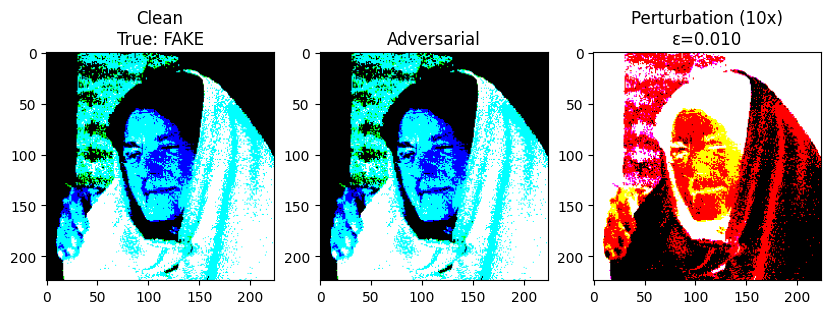

Clean prediction: 0.2875 (FAKE)
Adversarial prediction: 0.6269 (REAL)
Prediction change: -0.3394
Sample 5: Clean Acc: 1.000 | Robust Acc: 0.000
Sample 10: Clean Acc: 1.000 | Robust Acc: 0.000
Sample 15: Clean Acc: 0.933 | Robust Acc: 0.000
Sample 20: Clean Acc: 0.950 | Robust Acc: 0.000

Results for ε=0.010:
Clean Accuracy: 0.9500
Robust Accuracy: 0.0000
Attack Success: 1.0000
Time: 3.62s

=== Evaluating ε=0.020 ===


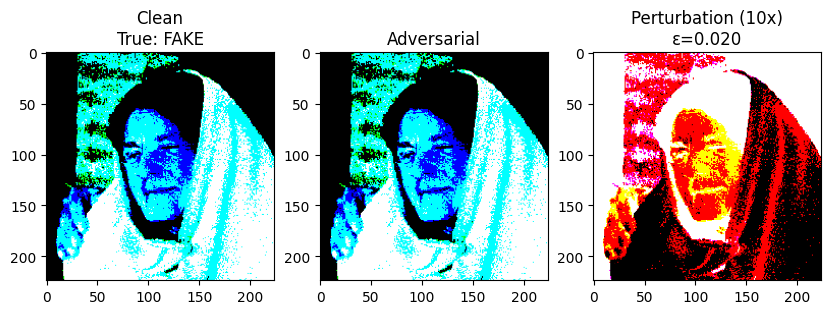

Clean prediction: 0.2875 (FAKE)
Adversarial prediction: 0.6270 (REAL)
Prediction change: -0.3395
Sample 5: Clean Acc: 1.000 | Robust Acc: 0.000
Sample 10: Clean Acc: 1.000 | Robust Acc: 0.000
Sample 15: Clean Acc: 0.933 | Robust Acc: 0.000
Sample 20: Clean Acc: 0.950 | Robust Acc: 0.000

Results for ε=0.020:
Clean Accuracy: 0.9500
Robust Accuracy: 0.0000
Attack Success: 1.0000
Time: 3.60s


In [44]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt

def fgsm_attack_single(model, x, y, eps=0.01):
    """Fixed FGSM implementation with proper shape handling"""
    x_tensor = tf.convert_to_tensor(x[np.newaxis, ...], dtype=tf.float32)
    y_tensor = tf.convert_to_tensor([[y]], dtype=tf.float32)  # Shape (1,1)
    
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        prediction = model(x_tensor)  # Shape (1,1)
        # Ensure shapes match
        loss = tf.keras.losses.binary_crossentropy(
            y_tensor, prediction, from_logits=False)
    
    gradient = tape.gradient(loss, x_tensor)
    perturbation = eps * tf.sign(gradient)
    x_adv = x_tensor + perturbation
    return tf.clip_by_value(x_adv, 0, 1)[0].numpy()  # Remove batch dim

def verify_attack(model, x_clean, x_adv, y_true, eps):
    """Visual verification with proper prediction handling"""
    plt.figure(figsize=(10, 4))
    
    # Show images
    plt.subplot(1, 3, 1)
    plt.imshow(x_clean)
    plt.title(f"Clean\nTrue: {'REAL' if y_true else 'FAKE'}")
    
    plt.subplot(1, 3, 2)
    plt.imshow(x_adv)
    plt.title("Adversarial")
    
    plt.subplot(1, 3, 3)
    plt.imshow(10*(x_adv-x_clean))
    plt.title(f"Perturbation (10x)\nε={eps:.3f}")
    
    plt.show()
    
    # Get predictions
    clean_pred = model.predict(x_clean[np.newaxis, ...], verbose=0)[0,0]
    adv_pred = model.predict(x_adv[np.newaxis, ...], verbose=0)[0,0]
    
    print(f"Clean prediction: {clean_pred:.4f} ({'REAL' if clean_pred > 0.5 else 'FAKE'})")
    print(f"Adversarial prediction: {adv_pred:.4f} ({'REAL' if adv_pred > 0.5 else 'FAKE'})")
    print(f"Prediction change: {clean_pred-adv_pred:.4f}")

def evaluate_robustness(model, test_gen, attack_fn, epsilons, max_samples=20):
    """Robust evaluation with proper shape handling"""
    results = {}
    
    # Get sample
    x_sample, y_sample = next(test_gen)
    x_sample = x_sample[0]  # First image
    y_sample = int(y_sample[0])  # Convert to scalar
    
    for eps in epsilons:
        test_gen.reset()
        total = 0
        successful_attacks = 0
        clean_correct = 0
        
        print(f"\n=== Evaluating ε={eps:.3f} ===")
        
        # Verify attack visually
        x_adv_sample = attack_fn(model, x_sample, y_sample, eps)
        verify_attack(model, x_sample, x_adv_sample, y_sample, eps)
        
        # Evaluate
        start_time = time.time()
        samples_processed = 0
        
        while samples_processed < max_samples:
            try:
                x_batch, y_batch = next(test_gen)
            except StopIteration:
                test_gen.reset()
                continue
                
            for i in range(len(y_batch)):
                if samples_processed >= max_samples:
                    break
                    
                x = x_batch[i]
                y = int(y_batch[i])  # Convert to scalar
                
                # Clean prediction
                clean_pred = model.predict(x[np.newaxis, ...], verbose=0)[0,0]
                clean_label = int(clean_pred > 0.5)
                
                # Generate adversarial
                x_adv = attack_fn(model, x, y, eps)
                
                # Adversarial prediction
                adv_pred = model.predict(x_adv[np.newaxis, ...], verbose=0)[0,0]
                adv_label = int(adv_pred > 0.5)
                
                # Update metrics
                total += 1
                if clean_label == y:
                    clean_correct += 1
                    if adv_label != y:
                        successful_attacks += 1
                
                samples_processed += 1
                
                # Print progress
                if total % 5 == 0:
                    if clean_correct > 0:
                        robust_acc = 1 - (successful_attacks / clean_correct)
                    else:
                        robust_acc = 0.0
                    print(f"Sample {total}: Clean Acc: {clean_correct/total:.3f} | Robust Acc: {robust_acc:.3f}")
        
        # Final results
        if clean_correct > 0:
            attack_success = successful_attacks / clean_correct
            robust_acc = 1 - attack_success
        else:
            attack_success = 0.0
            robust_acc = 0.0
            
        results[eps] = {
            'clean_accuracy': clean_correct/total,
            'robust_accuracy': robust_acc,
            'attack_success': attack_success,
            'samples': total
        }
        
        print(f"\nResults for ε={eps:.3f}:")
        print(f"Clean Accuracy: {clean_correct/total:.4f}")
        print(f"Robust Accuracy: {robust_acc:.4f}")
        print(f"Attack Success: {attack_success:.4f}")
        print(f"Time: {time.time()-start_time:.2f}s")
    
    return results

# Parameters
epsilons = [0.01, 0.02]  # Small epsilons first
max_samples = 20  # Start small

# Evaluation
print("=== FGSM Evaluation ===")
fgsm_results = evaluate_robustness(model, test_gen, fgsm_attack_single, epsilons, max_samples)

In [ ]:

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(fgsm_epsilons, [quick_fgsm[eps] for eps in fgsm_epsilons], 
         marker='o', label='FGSM')
plt.plot(pgd_epsilons, [quick_pgd[eps] for eps in pgd_epsilons], 
         marker='s', label='PGD')
plt.title('Model Robustness Under Adversarial Attacks')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.xticks(fgsm_epsilons)
plt.grid(True)
plt.legend()
plt.show()

In [2]:
import tensorflow as tf

from tensorflow.keras.models import clone_model
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

2025-04-14 22:58:30.937016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744671511.189468      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744671511.268288      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-v89brhh7/cleverhans_4679f826c2404d71b7581fd32c0ade30
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/cleverhans.git /tmp/pip-install-v89brhh7/cleverhans_4679f826c2404d71b7581fd32c0ade30
  Resolved https://github.com/tensorflow/cleverhans.git to commit 574efc1d2f5c7e102c78cf0e937654e847267522
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.2 MB/s eta 0:00:00
  Created wheel for cleverhans: filename=cleverhans-4.0.0-py3-none-any.whl size=92396 sha256=3f067615939131d6c8f38f8fff00778fa71da9d5b46e6d23b36ef28de1400f66
  Stored in directory: /tmp/pip-ephem-wheel-cache-vrz8l19m/wheels/27/7a/5d/a13b60d1ff5cdcfc534e602267baece552b7e9ebea77b6b134
Successfully built cleverhans


In [5]:


import cleverhans
from cleverhans.tf2.attacks import fast_gradient_method, projected_gradient_descent
import numpy as np
import os
import shutil

# ==================================================================
# 1. Adversarial Attack Functions with Caching
# ==================================================================
class AdversarialCache:
    def __init__(self, cache_dir="/kaggle/working/adv_cache"):
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)
        
    def get_path(self, attack_name, epoch, step):
        return os.path.join(self.cache_dir, f"{attack_name}_e{epoch}_s{step}.npz")
    
    def load(self, attack_name, epoch, step):
        path = self.get_path(attack_name, epoch, step)
        if os.path.exists(path):
            data = np.load(path)
            return tf.convert_to_tensor(data['x'], dtype=tf.float32)
        return None
    
    def save(self, x_adv, attack_name, epoch, step):
        path = self.get_path(attack_name, epoch, step)
        np.savez_compressed(path, x=x_adv.numpy())

cache = AdversarialCache()

def generate_adversarial_batch(model, x_batch, y_batch, attack_fn, attack_params, 
                              attack_name, epoch, step):
    cached = cache.load(attack_name, epoch, step)
    if cached is not None:
        return cached
    
    x_adv = attack_fn(model, x_batch, y_batch, **attack_params)
    cache.save(x_adv, attack_name, epoch, step)
    return x_adv

# ==================================================================
# 2. Adversarial Training Models
# ==================================================================
def create_adv_model(base_model, attack_type):
    """Create new model instance for adversarial training"""
    adv_model = clone_model(base_model)
    adv_model.set_weights(base_model.get_weights())
    adv_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    adv_model.attack_type = attack_type  # 'fgsm' or 'pgd'
    return adv_model

# ==================================================================
# 3. Training Configuration
# ==================================================================
ATTACK_PARAMS = {
    'fgsm': {'eps': 0.03},
    'pgd': {'eps': 0.03, 'eps_iter': 0.01, 'nb_iter': 10}
}

BATCH_SIZE = 32
ADV_RATIO = 0.5  # 50% adversarial examples in each batch

# ==================================================================
# 4. Adversarial Training Loop
# ==================================================================
def adversarial_train(model, train_gen, val_gen, epochs=3):
    optimizer = tf.keras.optimizers.Adam(1e-4)
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    attack_type = model.attack_type
    
    # Create progress callback
    class ProgressCallback(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            self.epoch = epoch + 1
            print(f"\nEpoch {self.epoch}/{epochs}")
            
        def on_train_batch_begin(self, batch, logs=None):
            print(f"\r  Batch {batch+1}/{len(train_gen)}", end='')

    # Custom training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        prog_callback = ProgressCallback()
        
        for step, (x_batch, y_batch) in enumerate(train_gen):
            x_batch = tf.convert_to_tensor(x_batch, dtype=tf.float32)
            y_batch = tf.convert_to_tensor(y_batch, dtype=tf.float32)
            
            # Split batch into clean and adversarial portions
            split_idx = int(BATCH_SIZE * (1 - ADV_RATIO))
            x_clean = x_batch[:split_idx]
            y_clean = y_batch[:split_idx]
            
            # Generate adversarial examples
            x_adv = generate_adversarial_batch(
                model, x_batch[split_idx:], y_batch[split_idx:],
                attack_fn=fast_gradient_method if attack_type == 'fgsm' else projected_gradient_descent,
                attack_params=ATTACK_PARAMS[attack_type],
                attack_name=attack_type,
                epoch=epoch,
                step=step
            )
            
            # Combine clean and adversarial samples
            x_mixed = tf.concat([x_clean, x_adv], axis=0)
            y_mixed = tf.concat([y_clean, y_batch[split_idx:]], axis=0)
            
            # Training step
            with tf.GradientTape() as tape:
                preds = model(x_mixed, training=True)
                loss = loss_fn(y_mixed, preds)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            print(f"\r  Batch {step+1}/{len(train_gen)}", end='')
        
        # Validation
        val_acc = tf.keras.metrics.BinaryAccuracy()
        for x_val, y_val in val_gen:
            val_acc.update_state(y_val, model(x_val, training=False))
        print(f"\nValidation Accuracy: {val_acc.result().numpy():.4f}")

    return model

# ==================================================================
# 5. Main Execution Flow
# ==================================================================
# Load baseline model
baseline_model = tf.keras.models.load_model('/kaggle/input/dfri_vgg19_baseline/keras/default/1/vgg19_deepfake_model.keras')

# Create adversarial models
fgsm_model = create_adv_model(baseline_model, 'fgsm')


In [ ]:
pgd_model = create_adv_model(baseline_model, 'pgd')

# Train FGSM model
print("\nTraining FGSM-Robust Model...")
fgsm_model = adversarial_train(fgsm_model, train_gen, val_gen, epochs=3)
fgsm_model.save('/kaggle/working/vgg19_fgsm_robust.keras')

# Train PGD model
print("\nTraining PGD-Robust Model...")
pgd_model = adversarial_train(pgd_model, train_gen, val_gen, epochs=3)
pgd_model.save('/kaggle/working/vgg19_pgd_robust.keras')

# ==================================================================
# 6. Comprehensive Evaluation
# ==================================================================
def evaluate_model(model, test_gen, attack_fn=None):
    # Clean accuracy
    clean_acc = model.evaluate(test_gen, verbose=0)[1]
    
    # Adversarial accuracy
    if attack_fn:
        x_test, y_test = next(test_gen)
        x_adv = attack_fn(model, x_test, y_test, **ATTACK_PARAMS[model.attack_type])
        adv_acc = model.evaluate(x_adv, y_test, verbose=0)[1]
        return clean_acc, adv_acc
    return clean_acc, None

# Evaluate all models
print("\nEvaluating Models:")
models = {
    'Baseline': baseline_model,
    'FGSM-Robust': fgsm_model,
    'PGD-Robust': pgd_model
}

results = {}
for name, model in models.items():
    test_gen.reset()
    if 'FGSM' in name:
        clean, adv = evaluate_model(model, test_gen, fast_gradient_method)
    elif 'PGD' in name:
        clean, adv = evaluate_model(model, test_gen, projected_gradient_descent)
    else:
        clean, adv = evaluate_model(model, test_gen)
    
    results[name] = {
        'Clean': clean,
        'Adversarial': adv if adv else model.evaluate(test_gen, verbose=0)[1]
    }
    print(f"{name}:")
    print(f"  Clean Accuracy: {results[name]['Clean']:.4f}")
    if adv:
        print(f"  {model.attack_type.upper()} Robustness: {results[name]['Adversarial']:.4f}")

# ==================================================================
# 7. Save All Models
# ==================================================================
print("\nSaving all models...")
baseline_model.save('/kaggle/working/vgg19_baseline.keras')
fgsm_model.save('/kaggle/working/vgg19_fgsm_robust.keras')
pgd_model.save('/kaggle/working/vgg19_pgd_robust.keras')
print("All models saved successfully!")



#